In [71]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mp
from matplotlib.colors import LogNorm
from scipy.signal import convolve2d
from scipy.signal import convolve
import copy
import json
import time as tm

In [52]:
side_len = 75 #microns
cell_size = 5 #microns
cell_to_diff_ratio = 1
density = 5 #mm^-2

In [53]:
n_strains = 2
n_nutrients = 2

#The dependencies of strain the strains on each nutrient. Within each strain and nutrient, COLUMN 1 is UPTAKE, 
#COLUMN 2 is RELEASE. 1 means they do that function, 0 means they do not
dependencies = np.zeros((n_strains,n_nutrients,2))

dependencies[0,0,0] = 1 #strain 1, uptake nutrient 1
dependencies[0,1,1] = 1 #strain 1, release nutrient 2

dependencies[1,1,0] = 1 #strain 2, uptake nutrient 2
dependencies[1,0,1] = 1 #strain 2, release nutrient 1

In [61]:
def generate_matricies(side_len,cell_size,cell_to_diff_ratio):

    cell_sides = int(side_len/cell_size)
    X = np.zeros((cell_sides,cell_sides,cell_sides))

    #the boxes for each nutrient
    diff_sides = int(cell_sides/cell_to_diff_ratio)

    #The blank matrix into which nutrients will go
    S = np.zeros((n_nutrients,diff_sides,diff_sides,diff_sides))
    indicies = np.arange(diff_sides)

    #lets make a distances array so that we don't have to calculate it each time
    side = np.arange(diff_sides)*cell_size*cell_to_diff_ratio
    #print(np.shape(side))
    SQ = np.add.outer(np.square(side),np.square(side))
    #print(np.shape(SQ))
    QB = np.add.outer(SQ,np.square(side))
    #print(np.shape(QB))
    distances = np.sqrt(QB)
    distances[0,0,0] = diff_sides/2
    
    return X,S,distances,indicies


In [62]:
class Cell:
    """Hold the properties and variables for strains."""
    def __init__(self,
                 x: int,
                 y: int,
                 z: int,
                 dependencies: np.ndarray,
                 d: float,
                 typ: int,
                 cell_to_diff_ratio: float
                ):
        
        self.x = x
        self.y = y
        self.z = z
        
        #location in the nutrient grid
        self.i = int(x // cell_to_diff_ratio)
        self.j = int(y // cell_to_diff_ratio)
        self.k = int(z // cell_to_diff_ratio)
        
        self.dependencies = dependencies
        self.life_flag = True
        self.quiescence_flag = False
        self.death_rate = d
        self.typ = typ
        
    
    def create_daughter(self, x, y, z):
        """
        Create a daughter cell at the specified position
        Should return a new Cell instance with:
        - Same dependencies and parameters as parent
        - New position (x, y, z)
        - Zero internal nutrients
        """
        daughter = Cell(x,y,z,
                        self.dependencies,
                        self.death_rate,
                        self.typ,
                        cell_to_diff_ratio
                       )
        return daughter

In [63]:
#initial condition to test
x,y,z = 10,7,5

strain_identifier = 1
cells = [None]*1
cells[0] = Cell(x,y,z,
                dependencies[strain_identifier,:,:],
                0.1,
                int(strain_identifier+1),
                cell_to_diff_ratio
               )

X,S,distances,indicies = generate_matricies(side_len,cell_size,cell_to_diff_ratio)

X[x,y,z] = strain_identifier

In [64]:
def calculate_greens_function(S,distances,DS,betas,gammas,cell,nn,indicies):
    
    l = np.sqrt(DS[nn]/betas[nn])
    prefac = gammas[nn]/(4*DS[nn]*np.pi)
    
    xes = np.abs(indicies.copy()-cell.i)
    yes = np.abs(indicies.copy()-cell.j)
    zes = np.abs(indicies.copy()-cell.k)

    r = distances.copy()[xes[:,None,None],
                yes[None,:,None],
                zes[None,None,:]]

    G_of_r = prefac*np.power(r,-1)*np.exp(-r/l)
    
    return G_of_r

In [74]:
def plot_greens(X,G_of_r,x,y,z):
    
    fs = 50
    
    plt_number = 0
    
    fig, ax = plt.subplots(2,3,figsize=(50,25))
    ax[0,0].imshow(X[:,:,z], cmap='hot')
    ax[0,0].set_title('strain location XY',fontsize=fs)
    ax[0,0].axis('off')
        
    ax[1,0].imshow(G_of_r[:,:,z], cmap='Greys',norm=LogNorm(vmin=np.amin(G_of_r), vmax=np.amax(G_of_r)))
    ax[1,0].set_title('Greens function XY',fontsize=fs)
    ax[1,0].axis('off')
    
    ax[0,1].imshow(X[:,y,:], cmap='hot')
    ax[0,1].set_title('strain location XZ',fontsize=fs)
    ax[0,1].axis('off')
    
    ax[1,1].imshow(G_of_r[:,y,:], cmap='Greys',norm=LogNorm(vmin=np.amin(G_of_r), vmax=np.amax(G_of_r)))
    ax[1,1].set_title('Greens function XZ',fontsize=fs)
    ax[1,1].axis('off')
    
    ax[0,2].imshow(X[x,:,:], cmap='hot')
    ax[0,2].set_title('strain location YZ',fontsize=fs)
    ax[0,2].axis('off')
    
    ax[1,2].imshow(G_of_r[x,:,:], cmap='Greys',norm=LogNorm(vmin=np.amin(G_of_r), vmax=np.amax(G_of_r)))
    ax[1,2].set_title('Greens function YZ',fontsize=fs)
    ax[1,2].axis('off')
    
    plt.show()

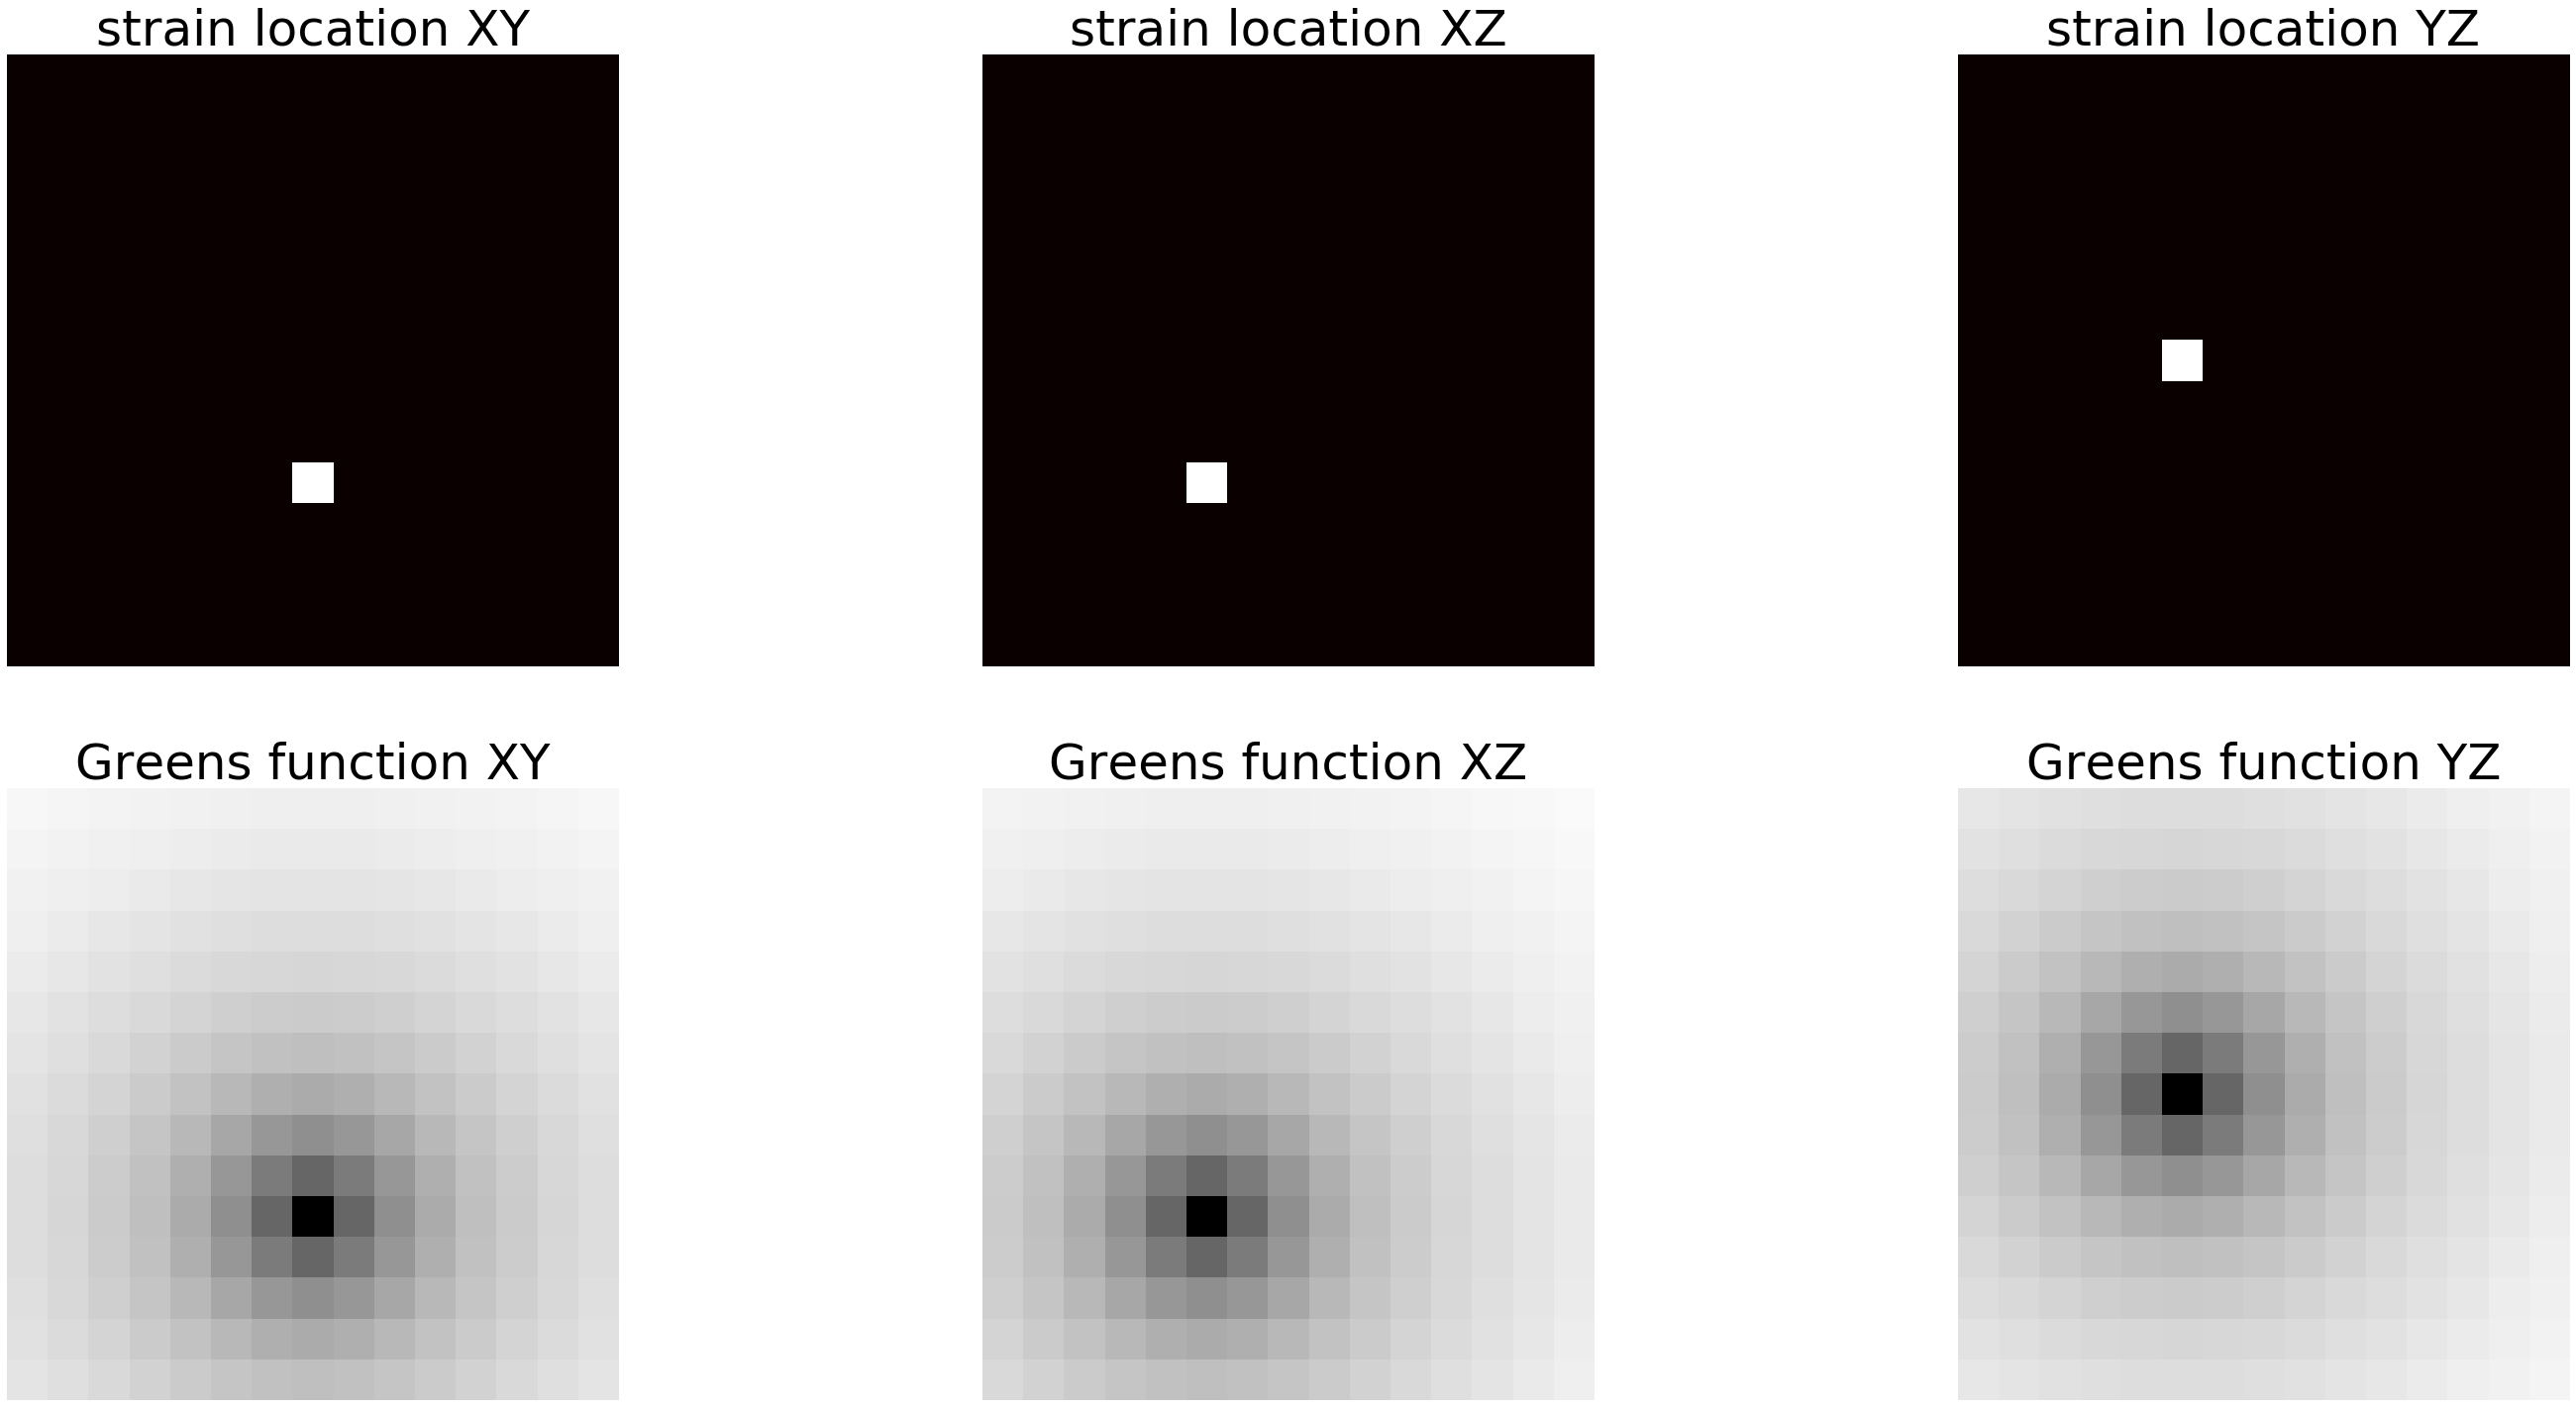

In [79]:
G_of_r = calculate_greens_function(S,distances,[14,14],[0.001,0.001],[0.4,0.25],cells[0],1,indicies)

plot_greens(X,G_of_r,x,y,z)

In [80]:
print(np.unique(G_of_r))

[9.87283562e-06 1.03527590e-05 1.05099204e-05 1.05903044e-05
 1.07967628e-05 1.10554522e-05 1.11444818e-05 1.11895419e-05
 1.13269608e-05 1.15155961e-05 1.15637557e-05 1.16613140e-05
 1.17605624e-05 1.19127071e-05 1.19643191e-05 1.20163903e-05
 1.20689271e-05 1.21219363e-05 1.21754246e-05 1.23388342e-05
 1.23943098e-05 1.24503005e-05 1.25068142e-05 1.25638586e-05
 1.26795716e-05 1.27975055e-05 1.28573267e-05 1.29177292e-05
 1.29787220e-05 1.30403144e-05 1.31025158e-05 1.32928724e-05
 1.34890719e-05 1.35558201e-05 1.36232611e-05 1.36914065e-05
 1.38298582e-05 1.39001890e-05 1.40431239e-05 1.41157545e-05
 1.41891784e-05 1.42634098e-05 1.44143526e-05 1.44910936e-05
 1.45687015e-05 1.46471922e-05 1.47265817e-05 1.48068868e-05
 1.48881245e-05 1.50534683e-05 1.51376108e-05 1.52227587e-05
 1.53089315e-05 1.53961492e-05 1.54844323e-05 1.55738018e-05
 1.57558875e-05 1.58486488e-05 1.60377260e-05 1.61340911e-05
 1.62317077e-05 1.63306023e-05 1.65323346e-05 1.66352292e-05
 1.67395154e-05 1.684522